# Profiling

In [4]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'c:\\Users\\jaesc2\\GitHub\\skforecast'

In [5]:
import platform
import psutil
import skforecast
import pandas as pd
import numpy as np
import scipy
import sklearn

import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor

from skforecast.recursive import ForecasterRecursive
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.model_selection import grid_search_forecaster_multiseries
from skforecast.model_selection import bayesian_search_forecaster_multiseries
from skforecast.model_selection import backtesting_forecaster_multiseries
from skforecast.utils import *

from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
from skforecast.datasets import fetch_dataset

%load_ext pyinstrument
%load_ext line_profiler

# Information system and libraries

In [6]:
# Versions
# ==============================================================================
print(f"Python version: {platform.python_version()}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"skforecast version: {skforecast.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"scipy version: {scipy.__version__}")
print(f"psutil version: {psutil.__version__}")
print("")

# Computer information
# ==============================================================================
#Computer network name
print(f"Computer network name: {platform.node()}")
#Machine type
print(f"Machine type: {platform.machine()}")
#Processor type
print(f"Processor type: {platform.processor()}")
#Platform type
print(f"Platform type: {platform.platform()}")
#Operating system
print(f"Operating system: {platform.system()}")
#Operating system release
print(f"Operating system release: {platform.release()}")
#Operating system version
print(f"Operating system version: {platform.version()}")
#Physical cores
print(f"Number of physical cores: {psutil.cpu_count(logical=False)}")
#Logical cores
print(f"Number of logical cores: {psutil.cpu_count(logical=True)}")

Python version: 3.11.10
scikit-learn version: 1.6.1
skforecast version: 0.16.0
pandas version: 2.2.3
numpy version: 2.1.3
scipy version: 1.15.2
psutil version: 7.0.0

Computer network name: ITES015-NB0029
Machine type: AMD64
Processor type: Intel64 Family 6 Model 141 Stepping 1, GenuineIntel
Platform type: Windows-10-10.0.19045-SP0
Operating system: Windows
Operating system release: 10
Operating system version: 10.0.19045
Number of physical cores: 8
Number of logical cores: 16


# ForecasterRecursive

In [81]:
len_y = 1_000_000
y = pd.Series(
    data = np.random.rand(len_y),
    index = pd.date_range(
        start='2020-01-01',
        periods=len_y,
        freq='h'
    )
)

n_exog = 300
exog = pd.DataFrame(
    data = np.random.rand(len_y, n_exog),
    index = pd.date_range(
        start='2020-01-01',
        periods=len_y,
        freq='h'
    ),
    columns = [f'exog_{i}' for i in range(n_exog)]
)

exog_predict = pd.DataFrame(
    data = np.random.rand(1000, n_exog),
    index = pd.date_range(
        start='2134-01-29 16:00:00',
        periods=1000,
        freq='h'
    ),
    columns = [f'exog_{i}' for i in range(n_exog)]
)

print(f"y dates: {y.index.min()} - {y.index.max()}")
print(f"exog dates: {exog.index.min()} - {exog.index.max()}")
print(f"exog_predict dates: {exog_predict.index.min()} - {exog_predict.index.max()}")

y dates: 2020-01-01 00:00:00 - 2134-01-29 15:00:00
exog dates: 2020-01-01 00:00:00 - 2134-01-29 15:00:00
exog_predict dates: 2134-01-29 16:00:00 - 2134-03-12 07:00:00


In [42]:
%%timeit

exog.select_dtypes(include=np.number).shape[1] != exog.shape[1]

2.65 s ± 111 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [82]:
%%timeit

not all(
    pd.api.types.is_numeric_dtype(dtype) for dtype in exog.dtypes
)

270 μs ± 15.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [83]:
%%timeit

not all(
    pd.api.types.is_numeric_dtype(dtype) and not pd.api.types.is_bool_dtype(dtype) for dtype in exog.dtypes
)

449 μs ± 6.42 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [84]:
%%timeit

any(
    not pd.api.types.is_numeric_dtype(dtype) or pd.api.types.is_bool_dtype(dtype) 
    for dtype in exog.dtypes
)

445 μs ± 4.87 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [85]:
%%timeit

any(
    not pd.api.types.is_numeric_dtype(dtype) or pd.api.types.is_bool_dtype(dtype) 
    for dtype in set(exog.dtypes)
)

44.1 μs ± 671 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [86]:
set(exog.dtypes)

{dtype('float64')}

In [76]:
%%timeit

valid_dtypes = ("int", "Int", "float", "Float", "uint")

not all(
    (dtype_name.startswith(valid_dtypes) or dtype_name == "category") 
    for dtype_name in set(exog.dtypes.astype(str))
)

1e+03 μs ± 11.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [61]:
%%timeit

valid_dtypes = ("int", "Int", "float", "Float", "uint", "category")

not all(
    (dtype_name.startswith(valid_dtypes)) 
    for dtype_name in set(exog.dtypes.astype(str))
)

58 μs ± 225 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [87]:
exog = pd.DataFrame({
            # 'exog_1': [False] * 10,
            'exog_2': ['True'] * 10,
            'exog_3': np.arange(10),
        })
exog.dtypes

exog_2    object
exog_3     int64
dtype: object

In [88]:
exog.select_dtypes(include=np.number).shape[1] != exog.shape[1]

True

In [89]:
not all(
    pd.api.types.is_numeric_dtype(dtype) and not pd.api.types.is_bool_dtype(dtype) 
    for dtype in exog.dtypes
)

True

In [90]:
any(
    not pd.api.types.is_numeric_dtype(dtype) or pd.api.types.is_bool_dtype(dtype) 
    for dtype in set(exog.dtypes)
)

True

In [30]:
y = pd.Series(np.arange(10), dtype=float)
exog = pd.DataFrame({
            'exog_1': [False] * 10,
            'exog_2': [True] * 10,
        })
forecaster = ForecasterRecursive(LGBMRegressor(), lags=5)
results = forecaster._create_train_X_y(y=y, exog=exog)
results[0]

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : DataTypeWarning                                                           │
│ Location : c:\Users\jaesc2\GitHub\skforecast\skforecast\utils\utils.py:635           │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

,lag_1,lag_2,lag_3,lag_4,lag_5,exog_1,exog_2
5,4.0,3.0,2.0,1.0,0.0,0.0,1.0
6,5.0,4.0,3.0,2.0,1.0,0.0,1.0
7,6.0,5.0,4.0,3.0,2.0,0.0,1.0
8,7.0,6.0,5.0,4.0,3.0,0.0,1.0
9,8.0,7.0,6.0,5.0,4.0,0.0,1.0


In [5]:
# Forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
    regressor=LGBMRegressor(random_state=8520, verbose=-1),
    lags=50,
    transformer_y=StandardScaler(),
    transformer_exog=StandardScaler()
)

In [6]:
# %%timeit -n 3 -r 2

# forecaster.fit(series=series_dict, exog=exog_dict)

_     ._   __/__   _ _  _  _ _/_   Recorded: 11:14:53  Samples:  256
 /_//_/// /_\ / //_// / //_'/ //     Duration: 45.868    CPU time: 255.781
/   _/                      v5.0.0

Cell [7]

45.867 <module>  ..\..\AppData\Local\Temp\ipykernel_27736\2640464880.py:1
`- 45.867 ForecasterRecursive.fit  skforecast\recursive\_forecaster_recursive.py:908
   |- 36.043 LGBMRegressor.fit  lightgbm\sklearn.py:1172
   |     [6 frames hidden]  lightgbm
   |        23.975 Booster.update  lightgbm\basic.py:4073
   |        10.225 Dataset.__init_from_np2d  lightgbm\basic.py:2286
   |- 8.638 ForecasterRecursive._create_train_X_y  skforecast\recursive\_forecaster_recursive.py:577
   |  |- 6.751 transform_dataframe  skforecast\utils\utils.py:2025
   |  |  `- 6.748 StandardScaler.wrapped  sklearn\utils\_set_output.py:317
   |  |        [30 frames hidden]  sklearn, numpy, <built-in>
   |  `- 1.321 [self]  skforecast\recursive\_forecaster_recursive.py
   `- 1.101 LGBMRegressor.predict  lightgbm\sklearn.py:992
         [4 frames hidden]  lightgbm
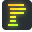

In [7]:
%%pyinstrument
forecaster.fit(y=y, exog=exog)

In [8]:
# Profiling fit()
# ==============================================================================
def funt_to_profile(forecaster, y, exog):
    forecaster.fit(y=y, exog=exog)

%lprun -f forecaster.fit funt_to_profile(forecaster, y, exog)

Timer unit: 1e-07 s

Total time: 47.0406 s
File: c:\Users\jaesc2\GitHub\skforecast\skforecast\recursive\_forecaster_recursive.py
Function: fit at line 908

Line #      Hits         Time  Per Hit   % Time  Line Contents
   908                                               def fit(
   909                                                   self,
   910                                                   y: pd.Series,
   911                                                   exog: pd.Series | pd.DataFrame | None = None,
   912                                                   store_last_window: bool = True,
   913                                                   store_in_sample_residuals: bool = False,
   914                                                   random_state: int = 123
   915                                               ) -> None:
   916                                                   """
   917                                                   Training Forecaster.
   918     

In [6]:
# Profiling _create_train_X_y()
# ==============================================================================
def funt_to_profile(forecaster, y, exog):
    forecaster._create_train_X_y_old(y=y, exog=exog)

%lprun -f forecaster._create_train_X_y_old funt_to_profile(forecaster, y, exog)

Timer unit: 1e-07 s

Total time: 12.3444 s
File: c:\Users\jaesc2\GitHub\skforecast\skforecast\recursive\_forecaster_recursive.py
Function: _create_train_X_y_old at line 777

Line #      Hits         Time  Per Hit   % Time  Line Contents
   777                                               def _create_train_X_y_old(
   778                                                   self,
   779                                                   y: pd.Series,
   780                                                   exog: pd.Series | pd.DataFrame | None = None
   781                                               ) -> tuple[
   782                                                   pd.DataFrame, 
   783                                                   pd.Series, 
   784                                                   list[str], 
   785                                                   list[str], 
   786                                                   list[str], 
   787                            

In [7]:
# Profiling _create_train_X_y()
# ==============================================================================
def funt_to_profile(forecaster, y, exog):
    forecaster._create_train_X_y(y=y, exog=exog)

%lprun -f forecaster._create_train_X_y funt_to_profile(forecaster, y, exog)

Timer unit: 1e-07 s

Total time: 8.1144 s
File: c:\Users\jaesc2\GitHub\skforecast\skforecast\recursive\_forecaster_recursive.py
Function: _create_train_X_y at line 577

Line #      Hits         Time  Per Hit   % Time  Line Contents
   577                                               def _create_train_X_y(
   578                                                   self,
   579                                                   y: pd.Series,
   580                                                   exog: pd.Series | pd.DataFrame | None = None
   581                                               ) -> tuple[
   582                                                   pd.DataFrame, 
   583                                                   pd.Series, 
   584                                                   list[str], 
   585                                                   list[str], 
   586                                                   list[str], 
   587                                     

In [6]:
# Profiling predict()
# ==============================================================================
forecaster.fit(y=y, exog=exog)

def funt_to_profile(forecaster, steps, exog):
    forecaster.predict(steps=steps, exog=exog)

%lprun -f forecaster.predict funt_to_profile(forecaster, 100, exog_predict)

c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\sklearn\utils\deprecation.py:151: Future

Timer unit: 1e-07 s

Total time: 0.205979 s
File: c:\Users\jaesc2\GitHub\skforecast\skforecast\recursive\_forecaster_recursive.py
Function: predict at line 1422

Line #      Hits         Time  Per Hit   % Time  Line Contents
  1422                                               def predict(
  1423                                                   self,
  1424                                                   steps: int | str | pd.Timestamp,
  1425                                                   last_window: pd.Series | pd.DataFrame | None = None,
  1426                                                   exog: pd.Series | pd.DataFrame | None = None,
  1427                                                   check_inputs: bool = True
  1428                                               ) -> pd.Series:
  1429                                                   """
  1430                                                   Predict n steps ahead. It is an recursive process in which, each predicti

In [8]:
# Profiling _create_predict_inputs()
# ==============================================================================
def funt_to_profile(forecaster, steps, exog):
    (
        last_window_values,
        exog_values,
        prediction_index,
        steps
    ) = forecaster._create_predict_inputs(
        steps         = steps,
        #last_window  = forecaster.last_window_,
        exog         = exog,
        check_inputs = True
    )

%lprun -f forecaster._create_predict_inputs funt_to_profile(forecaster, 100, exog_predict)

Timer unit: 1e-07 s

Total time: 0.0139515 s
File: c:\Users\jaesc2\GitHub\skforecast\skforecast\recursive\_forecaster_recursive.py
Function: _create_predict_inputs at line 1091

Line #      Hits         Time  Per Hit   % Time  Line Contents
  1091                                               def _create_predict_inputs(
  1092                                                   self,
  1093                                                   steps: int | str | pd.Timestamp, 
  1094                                                   last_window: pd.Series | pd.DataFrame | None = None,
  1095                                                   exog: pd.Series | pd.DataFrame | None = None,
  1096                                                   predict_probabilistic: bool = False,
  1097                                                   use_in_sample_residuals: bool = True,
  1098                                                   use_binned_residuals: bool = True,
  1099                        

In [7]:
# Profiling check_predict_input()
# ==============================================================================
def funt_to_profile(forecaster, steps, exog):

    check_predict_input(
    forecaster_name  = type(forecaster).__name__,
    steps            = steps,
    is_fitted        = forecaster.is_fitted,
    exog_in_         = forecaster.exog_in_,
    index_type_      = forecaster.index_type_,
    index_freq_      = forecaster.index_freq_,
    window_size      = forecaster.window_size,
    last_window      = forecaster.last_window_,
    exog             = exog,
    exog_type_in_    = forecaster.exog_type_in_,
    exog_names_in_   = forecaster.exog_names_in_,
    interval         = None
)

%lprun -f check_predict_input funt_to_profile(forecaster, 100, exog_predict)


Timer unit: 1e-07 s

Total time: 0.0008981 s
File: c:\Users\jaesc2\GitHub\skforecast\skforecast\utils\utils.py
Function: check_predict_input at line 762

Line #      Hits         Time  Per Hit   % Time  Line Contents
   762                                           def check_predict_input(
   763                                               forecaster_name: str,
   764                                               steps: int | list[int],
   765                                               is_fitted: bool,
   766                                               exog_in_: bool,
   767                                               index_type_: type,
   768                                               index_freq_: str,
   769                                               window_size: int,
   770                                               last_window: pd.Series | pd.DataFrame | None,
   771                                               last_window_exog: pd.Series | pd.DataFrame | None = 

In [11]:
# Profiling _backtesting_forecaster_multiseries()
# ==============================================================================
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster_multiseries
from skforecast.model_selection._validation import _backtesting_forecaster_multiseries

cv = TimeSeriesFold(
         steps                 = 50,
         initial_train_size    = 1500,
         refit                 = False,
         fixed_train_size      = False,
         gap                   = 0,
         allow_incomplete_fold = True,
         verbose               = False
     )

def funt_to_profile(forecaster, series, exog, cv):
    
    metric, predictions = _backtesting_forecaster_multiseries(
                          forecaster    = forecaster,
                          series        = series,
                          exog          = exog,
                          cv            = cv,
                          metric        = 'mean_squared_error',
                          n_jobs        = 'auto',
                          verbose       = False,
                          show_progress = True
                      )

%lprun -f _backtesting_forecaster_multiseries funt_to_profile(forecaster, series_dict, exog_dict, cv)

  0%|          | 0/10 [00:00<?, ?it/s]

Timer unit: 1e-09 s

Total time: 80.613 s
File: /home/joaquin/Documents/GitHub/skforecast/skforecast/model_selection/_validation.py
Function: _backtesting_forecaster_multiseries at line 559

Line #      Hits         Time  Per Hit   % Time  Line Contents
   559                                           def _backtesting_forecaster_multiseries(
   560                                               forecaster: object,
   561                                               series: pd.DataFrame | dict[str, pd.Series | pd.DataFrame],
   562                                               cv: TimeSeriesFold,
   563                                               metric: str | Callable | list[str | Callable],
   564                                               levels: str | list[str] | None = None,
   565                                               add_aggregated_metric: bool = True,
   566                                               exog: pd.Series | pd.DataFrame | dict[str, pd.Series | pd.DataF

In [ ]:
# Profiling align_series_and_exog_multiseries()
# ==============================================================================
# def funt_to_profile(series_dict, input_series_is_dict, exog_dict):
#     align_series_and_exog_multiseries(
#         series_dict=series_dict,
#         input_series_is_dict=input_series_is_dict,
#         exog_dict = exog_dict,
#     )

# %lprun -f align_series_and_exog_multiseries funt_to_profile(series_dict_train, True, exog_dict_train)

: 

: 

In [14]:
# Profiling check_preprocess_exog_multiseries()
# ==============================================================================
series_indexes = {k: v.index for k, v  in series_dict.items()}
series_col_names = list(series_dict.keys())

def funt_to_profile(input_series_is_dict, series_indexes, series_col_names, exog, exog_dict):
    check_preprocess_exog_multiseries(
        input_series_is_dict = input_series_is_dict,
        series_indexes = series_indexes,
        series_names_in_ = series_col_names,
        exog = exog_dict,
        exog_dict = exog_dict,
    )

%lprun -f check_preprocess_exog_multiseries funt_to_profile(True, series_indexes, series_col_names, exog, exog_dict)

Timer unit: 1e-09 s

Total time: 0.198148 s

Could not find file <string>
Are you sure you are running this program from the same directory
that you ran the profiler from?
Continuing without the function's contents.

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           
     2                                           
     3                                           
     4                                           
     5                                           
     6                                           
     7                                           
     8                                           
     9                                           
    10                                           
    11                                           
    12                                           
    13                                           
    14                                           
    15              

In [30]:
from skforecast.utils import check_exog
from skforecast.exceptions import DataTypeWarning
import warnings

def check_exog_dtypes(
    exog: pd.Series | pd.DataFrame,
    call_check_exog: bool = True,
    series_id: str = "`exog`"
) -> None:
    """

    """

    if call_check_exog:
        check_exog(exog=exog, allow_nan=False, series_id=series_id)

    if isinstance(exog, pd.DataFrame):
        if not exog.select_dtypes(exclude=[np.number, 'category']).columns.empty:
            warnings.warn(
                f"{series_id} may contain only `int`, `float` or `category` dtypes. "
                f"Most machine learning models do not allow other types of values. "
                f"Fitting the forecaster may fail.", 
                DataTypeWarning
            )
        for col in exog.select_dtypes(include='category'):
            if exog[col].cat.categories.dtype not in [int, np.int32, np.int64]:
                raise TypeError(
                    "Categorical dtypes in exog must contain only integer values. "
                    "See skforecast docs for more info about how to include "
                    "categorical features https://skforecast.org/"
                    "latest/user_guides/categorical-features.html"
                )
    else:
        if exog.dtype.name not in ['int', 'int8', 'int16', 'int32', 'int64', 'float', 
        'float16', 'float32', 'float64', 'uint8', 'uint16', 'uint32', 'uint64', 'category']:
            warnings.warn(
                f"{series_id} may contain only `int`, `float` or `category` dtypes. Most "
                f"machine learning models do not allow other types of values. "
                f"Fitting the forecaster may fail.", 
                DataTypeWarning
            )
        if exog.dtype.name == 'category' and exog.cat.categories.dtype not in [int,
        np.int32, np.int64]:
            raise TypeError(
                "Categorical dtypes in exog must contain only integer values. "
                "See skforecast docs for more info about how to include "
                "categorical features https://skforecast.org/"
                "latest/user_guides/categorical-features.html"
            )
        

def check_exog_dtypes_new(
    exog: pd.Series | pd.DataFrame,
    call_check_exog: bool = True,
    series_id: str = "`exog`"
) -> None:
    """
    Raise Exception if `exog` has categorical columns with non-integer values.
    Issue a Warning if `exog` has columns that are not numeric or categorical.
    """

    if call_check_exog:
        check_exog(exog=exog, allow_nan=False, series_id=series_id)

    valid_dtypes = {'int', 'int8', 'int16', 'int32', 'int64', 
                    'float', 'float16', 'float32', 'float64',
                    'uint8', 'uint16', 'uint32', 'uint64', 'category'}

    # --- DataFrame ---
    if isinstance(exog, pd.DataFrame):
        for col_name, dtype in exog.dtypes.items():

            # Si el tipo no es válido, emitir warning
            if dtype.name not in valid_dtypes:
                warnings.warn(
                    f"{series_id} may contain only `int`, `float` or `category` dtypes. "
                    f"Most machine learning models do not allow other types of values. "
                    f"Fitting the forecaster may fail.", 
                    DataTypeWarning
                )
                break  # basta con un warning, no es necesario seguir

        # Comprobación específica para columnas categóricas
        for col in exog.columns:
            if isinstance(exog[col].dtype, pd.CategoricalDtype):
                cat_dtype = exog[col].cat.categories.dtype
                if not np.issubdtype(cat_dtype, np.integer):
                    raise TypeError(
                        f"Categorical dtypes in exog must contain only integer values. "
                        f"Column '{col}' violates this constraint. "
                        "See skforecast docs for more info: "
                        "https://skforecast.org/latest/user_guides/categorical-features.html"
                    )

    # --- Series ---
    else:
        dtype = exog.dtype
        if dtype.name not in valid_dtypes:
            warnings.warn(
                f"{series_id} may contain only `int`, `float` or `category` dtypes. "
                f"Most machine learning models do not allow other types of values. "
                f"Fitting the forecaster may fail.", 
                DataTypeWarning
            )

        if isinstance(exog.dtype, pd.CategoricalDtype):
            cat_dtype = exog.cat.categories.dtype
            if not np.issubdtype(cat_dtype, np.integer):
                raise TypeError(
                    "Categorical dtypes in exog must contain only integer values. "
                    "See skforecast docs for more info: "
                    "https://skforecast.org/latest/user_guides/categorical-features.html"
                )
            

def check_exog_dtypes_3(
    exog: pd.Series | pd.DataFrame,
    call_check_exog: bool = True,
    series_id: str = "`exog`"
) -> None:
    """
    Comprueba que `exog` solo contenga dtypes numéricos o category con
    categorías enteras. 
    - Lanza TypeError si hay category con categorías no enteras.
    - Emite warning si detecta cualquier otro dtype.
    """

    if call_check_exog:
        check_exog(exog=exog, allow_nan=False, series_id=series_id)

    # 1. Detectar dtypes inválidos (solo necesitamos un warning)
    def _warn_if_invalid_dtype(dtype_name: str):
        warnings.warn(
            f"{series_id} may contain only `int`, `float` or `category` dtypes. "
            "Most machine learning models do not allow other types of values. "
            "Fitting the forecaster may fail.",
            DataTypeWarning
        )

    # Recorremos dtypes una sola vez
    if isinstance(exog, pd.DataFrame):
        for dtype_name in set(exog.dtypes.astype(str)):
            # Si no es numérico ni category, warning y cortamos
            if not (dtype_name.startswith(("int", "float", "uint")) or dtype_name == "category"):
                _warn_if_invalid_dtype(dtype_name)
                break

        # 2. Validar categorías solo en columnas categóricas
        for col in exog.columns:
            if isinstance(exog[col].dtype, pd.CategoricalDtype):
                cat_dtype = exog[col].cat.categories.dtype
                if not np.issubdtype(cat_dtype, np.integer):
                    raise TypeError(
                        f"Categorical dtypes in exog must contain only integer values. "
                        f"Column '{col}' has categories of type {cat_dtype}.\n"
                        "Consulta https://skforecast.org/latest/user_guides/categorical-features.html"
                    )

    else:
        # Serie única
        dtype_name = exog.dtype.name
        if not (pd.api.types.is_numeric_dtype(exog.dtype) or isinstance(exog.dtype, pd.CategoricalDtype)):
            _warn_if_invalid_dtype(dtype_name)

        if isinstance(exog.dtype, pd.CategoricalDtype):
            cat_dtype = exog.cat.categories.dtype
            if not np.issubdtype(cat_dtype, np.integer):
                raise TypeError(
                    "Categorical dtypes in exog must contain only integer values. "
                    f"Series has categories of type {cat_dtype}.\n"
                    "Consulta https://skforecast.org/latest/user_guides/categorical-features.html"
                )

In [ ]:
pd.api.types.is_numeric_dtype(pd.Series([True, True, True], name='exog').dtype)

True

: 

In [2]:
import pandas as pd

pd.DataFrame({'a': [1., 2., 3.], 'b': [True, True, True]}).dtypes.astype(str)

a    float64
b       bool
dtype: object

In [3]:
str(pd.Series([True, True, True], name='exog').dtypes)

'bool'

In [38]:
# Create DataFrame of 300 cols, 100000 rows and 1000 categories
n_cols = 500
n_rows = 100_000
n_categories = 1000
categories = [f'cat_{i}' for i in range(n_categories)]
np.random.seed(8520)
df = pd.DataFrame(
    np.random.randint(0, n_categories, size=(n_rows, n_cols)),
    columns=[f'col_{i}' for i in range(n_cols)]
)
df = df.astype('category')
df.head(3)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_490,col_491,col_492,col_493,col_494,col_495,col_496,col_497,col_498,col_499
0,639,80,614,229,847,989,211,907,803,276,...,743,467,549,598,107,917,305,395,56,144
1,457,222,246,46,995,394,244,842,712,990,...,937,940,476,200,948,182,699,29,698,670
2,553,343,515,638,415,608,89,859,448,616,...,317,180,975,210,942,321,248,215,89,710


In [46]:
cat_dtype = df['col_9'].cat.categories.dtype
print(cat_dtype)

np.issubdtype(np.int32, np.integer)

int32


True

In [31]:
%%timeit

check_exog_dtypes(df, call_check_exog=False, series_id='df')

51.4 ms ± 2.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
%%timeit

check_exog_dtypes_new(df, call_check_exog=False, series_id='df')

4.53 ms ± 579 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
%%timeit

check_exog_dtypes_3(df, call_check_exog=False, series_id='df')

4.31 ms ± 166 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
set(df.dtypes.astype(str))

{'category'}

In [39]:
%%timeit

for dtype_name in (exog.dtypes.astype(str)):
    # Si no es numérico ni category, warning y cortamos
    if not (dtype_name.startswith(("int", "float", "uint")) or dtype_name == "category"):
        break

2.23 ms ± 144 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [40]:
%%timeit

for dtype_name in set(exog.dtypes.astype(str)):
    # Si no es numérico ni category, warning y cortamos
    if not (dtype_name.startswith(("int", "float", "uint")) or dtype_name == "category"):
        break

2.07 ms ± 167 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
